In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import scipy.sparse as sp
import anndata as ad

In [2]:
SRA_to_condition = {
    "SRR16287104": "D20",
    "SRR16287105": "D15",
    "SRR16287106": "D10",
    "SRR16287107": "D6",
}

# Make AnnData from originial CSV files of D6-D30 samples from GSE185623

In [ ]:
adata = sc.read_csv("GSE185623/D6-D30_matrix.csv.gz")

In [4]:
adata.X

array([[0.       , 0.       , 0.       , ..., 0.6931472, 0.6931472,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.6931472,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.6931472, 1.3862944,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 1.0986123,
        0.       ]], shape=(14313, 29563), dtype=float32)

Data seems log transformed, we convert back to raw counts

In [5]:
adata.X = sp.csr_matrix(np.exp(adata.X) - 1)

In [6]:
adata.write_h5ad("GSE185623/adata_D6-D30.h5ad", compression="gzip")

In [7]:
adata = sc.read("GSE185623/adata_D6-D30.h5ad")

In [8]:
CellData = pd.read_csv("GSE185623/D6-D30_CellData.csv.gz", index_col=0)

In [9]:
CellData["full_bc"] = CellData.cell_bc_seqs.map(
    lambda x: x.split("_")[1].replace("-", "")
)

In [10]:
CellData = CellData.set_index("cell_bc_seqs")

In [11]:
adata.obs = adata.obs.join(CellData)

In [12]:
adata.obs.library_id.value_counts()

library_id
D10         3177
D15         2509
D20         1911
D6          1908
Unsort2b    1726
Unsort2a    1148
Unsort1b    1124
Unsort1a     810
Name: count, dtype: int64

In [13]:
merge_adata = adata.copy()

## Store individual AnnData objects for each library

In [14]:
original_adatas = {}
for library in SRA_to_condition.values():
    print(library)
    adata = merge_adata[merge_adata.obs.library_id == library].copy()

    sc.pp.filter_genes(adata, min_counts=1)
    sc.pp.filter_genes(adata, min_cells=1)
    adata.var["log10_n_counts_original"] = np.log10(adata.var.n_counts)
    adata.var["log10_n_cells_original"] = np.log10(adata.var.n_cells)
    adata.var.drop(columns=["n_cells", "n_counts"], inplace=True)

    sc.pp.filter_cells(adata, min_counts=1)
    sc.pp.filter_cells(adata, min_genes=1)
    adata.obs["log10_n_counts_original"] = np.log10(adata.obs.n_counts)
    adata.obs["log10_n_genes_original"] = np.log10(adata.obs.n_genes)
    adata.obs.drop(
        columns=[
            "time_id",
            "n_genes",
            "n_counts",
            "cell_names",
            "predicted_doublets",
            "n_counts_pre_norm",
        ],
        inplace=True,
    )

    adata.obs = adata.obs.set_index("full_bc")

    original_adatas[library] = adata

D20
D15
D10
D6


# STARsolo outputs

## Make individual AnnData objects for each library

In [ ]:
STARsolo_adatas = {}
for library in ["SRR16287107", "SRR16287106", "SRR16287105", "SRR16287104"]:
    adata = sc.read_mtx(f"{library}/Solo.out/GeneFull/raw/matrix.mtx").T
    adata.var = pd.read_table(
        f"{library}/Solo.out/GeneFull/raw/features.tsv",
        names=["gene_ids", "gene_symbols"],
        index_col=1,
    )

    adata.obs = pd.read_table(
        f"{library}/Solo.out/GeneFull/raw/barcodes.tsv", names=["barcodes"], index_col=0
    )

    adata = adata[original_adatas[SRA_to_condition[library]].obs.index].copy()

    sc.pp.filter_genes(adata, min_counts=1)
    adata.var_names_make_unique()
    sc.pp.filter_genes(adata, min_cells=1)
    adata.var["log10_n_counts_STARsolo"] = np.log10(adata.var.n_counts)
    adata.var["log10_n_cells_STARsolo"] = np.log10(adata.var.n_cells)
    adata.var.drop(columns=["n_cells", "n_counts", "gene_ids"], inplace=True)

    sc.pp.filter_cells(adata, min_counts=1)
    sc.pp.filter_cells(adata, min_genes=1)
    adata.obs["log10_n_counts_STARsolo"] = np.log10(adata.obs.n_counts)
    adata.obs["log10_n_genes_STARsolo"] = np.log10(adata.obs.n_genes)
    adata.obs.drop(columns=["n_genes", "n_counts"], inplace=True)

    STARsolo_adatas[SRA_to_condition[library]] = adata

# Make plots

### Comparing per cell and per gene count information in a 2 histogram as well log10 differences



#### Each row representss either information about cell counts or gene counts
#### For cells we have raw counts and how many genes each had
#### For gene we have raw counts and how many cells they were detected in


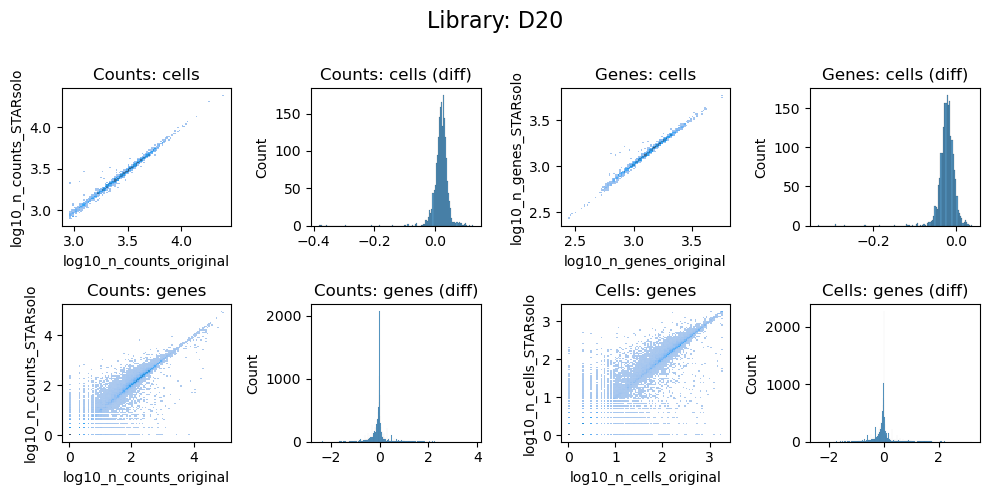

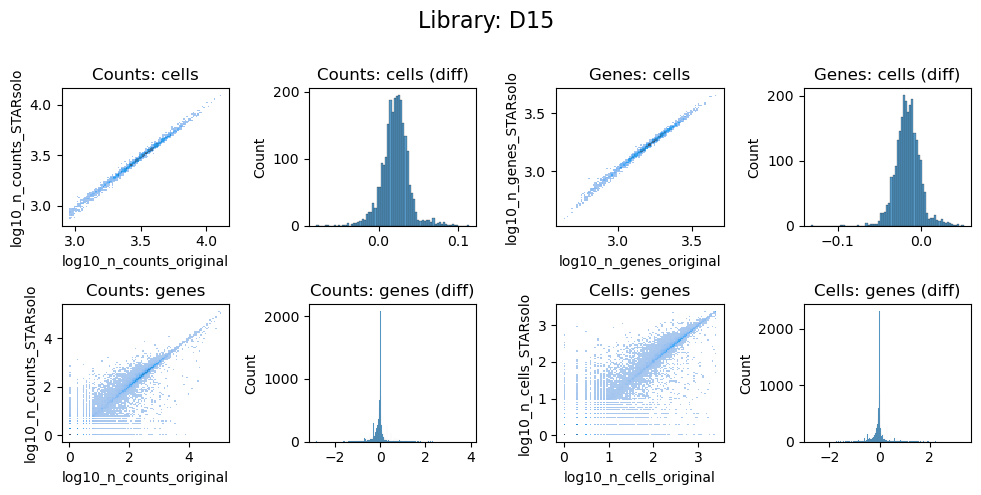

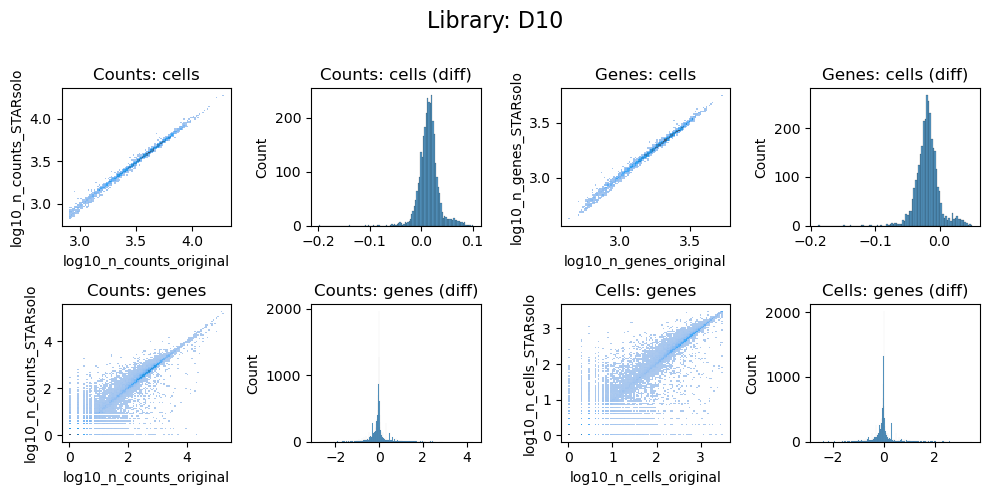

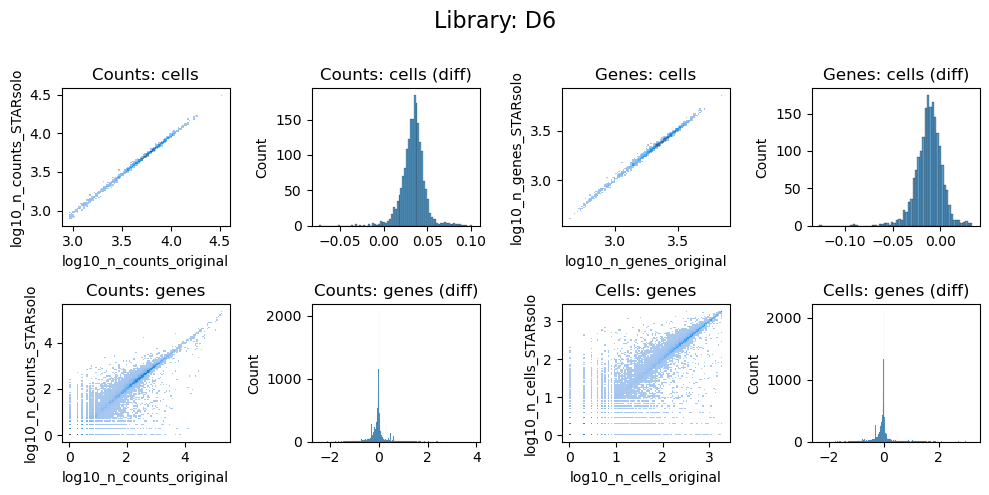

In [16]:
for library in SRA_to_condition.values():
    STARsolo_obs = STARsolo_adatas[library].obs
    original_obs = original_adatas[library].obs
    obs = STARsolo_obs.join(original_obs)

    STARsolo_var = STARsolo_adatas[library].var
    original_var = original_adatas[library].var
    var = STARsolo_var.join(original_var)

    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    fig.suptitle(f"Library: {library}", fontsize=16)

    # --- obs comparisons ---
    sns.histplot(
        data=obs,
        x="log10_n_counts_original",
        y="log10_n_counts_STARsolo",
        bins=100,
        ax=axes[0, 0],
    )
    axes[0, 0].set_title("Counts: cells")

    sns.histplot(
        obs.log10_n_counts_original - obs.log10_n_counts_STARsolo, ax=axes[0, 1]
    )
    axes[0, 1].set_title("Counts: cells (diff)")

    sns.histplot(
        data=obs,
        x="log10_n_genes_original",
        y="log10_n_genes_STARsolo",
        bins=100,
        ax=axes[0, 2],
    )
    axes[0, 2].set_title("Genes: cells")

    sns.histplot(obs.log10_n_genes_original - obs.log10_n_genes_STARsolo, ax=axes[0, 3])
    axes[0, 3].set_title("Genes: cells (diff)")

    # --- var comparisons ---
    sns.histplot(
        data=var,
        x="log10_n_counts_original",
        y="log10_n_counts_STARsolo",
        bins=100,
        ax=axes[1, 0],
    )
    axes[1, 0].set_title("Counts: genes")

    sns.histplot(
        var.log10_n_counts_original - var.log10_n_counts_STARsolo, ax=axes[1, 1]
    )
    axes[1, 1].set_title("Counts: genes (diff)")

    sns.histplot(
        data=var,
        x="log10_n_cells_original",
        y="log10_n_cells_STARsolo",
        bins=100,
        ax=axes[1, 2],
    )
    axes[1, 2].set_title("Cells: genes")

    sns.histplot(var.log10_n_cells_original - var.log10_n_cells_STARsolo, ax=axes[1, 3])
    axes[1, 3].set_title("Cells: genes (diff)")

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()